The S&P 500 dataset composes stock prices of 500 different American companies across various industries, in a period between early 2013 to early 2018. Each stock’s data is stored in a csv file, where prices such as open, close, highest, lowest and trading volume are recorded on a business daily basis.

Note that the list of companies of S&P 500 are periodically changing due to business activities, such as merging, acquisitions, shrinkage of company’s value and so on. This means those S&P 500 companies in the dataset could be different from those that are today.


In [2]:
# First import all the modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests

Since the dataset does not include background information about the companies, such as industries, year of establishment and so on. It would be hard to classify the companies according to their demographics for the analysis. 

To address this issue, the S&P information table on Wikipedia is referenced, which includes their demographics such as founding year, HQ location, sector and so on.

In [3]:
# Create a function to extract the table from wikipedia
def import_information_table():
    res = requests.get("http://en.wikipedia.org/wiki/List_of_S%26P_500_companies").text
    soup = BeautifulSoup(res, "html.parser")
    table = soup.find("table", id = "constituents")
    return pd.read_html(str(table))[0]

In [4]:
# Create the table
snf_table = import_information_table()

Lets look at the columns of the table.

In [5]:
print(snf_table.columns)

Index(['Symbol', 'Security', 'SEC filings', 'GICS Sector', 'GICS Sub Industry',
       'Headquarters Location', 'Date first added', 'CIK', 'Founded'],
      dtype='object')


It seems the column names are a bit too complicated, lets rename them as below.

In [6]:
# Rename the columns for easier reading
snf_table.columns = ["symbol", "security", "sec_filings", "sector", "sub_industry", \
                     "hq_location", "date_first_added", "cik", "founded"]


Now look at the brief structure of the table.

In [7]:
print(snf_table.head())

  symbol             security sec_filings                  sector  \
0    MMM           3M Company     reports             Industrials   
1    ABT  Abbott Laboratories     reports             Health Care   
2   ABBV          AbbVie Inc.     reports             Health Care   
3   ABMD          ABIOMED Inc     reports             Health Care   
4    ACN        Accenture plc     reports  Information Technology   

                     sub_industry              hq_location date_first_added  \
0        Industrial Conglomerates      St. Paul, Minnesota       1976-08-09   
1           Health Care Equipment  North Chicago, Illinois       1964-03-31   
2                 Pharmaceuticals  North Chicago, Illinois       2012-12-31   
3           Health Care Equipment   Danvers, Massachusetts       2018-05-31   
4  IT Consulting & Other Services          Dublin, Ireland       2011-07-06   

       cik      founded  
0    66740         1902  
1     1800         1888  
2  1551152  2013 (1888)  
3   81

The second column "security" is responsible for the name of the stocks, while the first column "symbol" is their abbreviation and also the name of their data file. (ie. Data of the "3M Company" is stored in the MMM_data.csv file in our folder)

There it seems the most logical way to classify the stocks for the analysis, is by their sector. For facilitate the analysis, a class "Sector" is created, which contains data of all the stocks in that sector.


In [8]:
# It seems the most appropriate way to classify the stocks is by their industrial sectors.
# A class "Sector" is created, which contains data of all the stocks in that sector.
class Sector:
    def __init__(self, sector_name):
        self.sector_name = sector_name
        self.sector_data_name = snf_table[snf_table["sector"] == sector_name]["symbol"]
        self.df = pd.DataFrame()
        self.sector_dict = {}

    # Importing all stock of the sector
    def import_all_data(self):
        for stock in self.sector_data_name:
            try:
                data_file = open("S&P500 Data/individual_stocks_5yr/individual_stocks_5yr/{name}_data.csv". \
                                 format(name=stock), "r")
                self.sector_dict[stock] = pd.read_csv(data_file)
            except OSError:
                print("This file does not exist: ", stock + "_data.csv")
        self.stock_names = list(self.sector_dict.keys())

    # Create a dataframe which contains the timestamp and all the price and volume data of all the stocks
    def create_dataframe(self):
        self.date = self.sector_dict[self.stock_names[0]]["date"]
        self.df = pd.DataFrame()
        self.df["date"] = self.date
        for stock in self.stock_names:
            self.sector_dict[stock].drop(["date", "Name"], axis=1, inplace=True)
            self.sector_dict[stock].columns = [str(name) + "_" + str(stock) for name in list(self.sector_dict[stock].columns)]
            self.df = self.df.join(self.sector_dict[stock])

    # Create any customized dataframe by choosing what variables to include
    def dataframe_by_price_type(self, type, df = pd.DataFrame()):
        if isinstance(type, str):  type = [type]
        if df.empty:
            df = self.df.copy(deep=True)
        dfvpt = pd.DataFrame(self.date)
        for col_name in list(df.columns)[1:]:
            for name in type:
                if name in col_name:
                    dfvpt = dfvpt.join(df[col_name])
        return dfvpt

    # Create a dataframe for a specific stock
    def stock(self, stock):
        cols = []
        for col in list(self.df.columns):
            if stock in col:
                cols.append(col)
        return pd.DataFrame(self.date).join(self.df[cols])

    # For plotting trend from the dataframe
    @staticmethod
    def plot_trend(df):
        plt.plot(pd.to_datetime(df.iloc[:,0]), df.iloc[:,1:])
        plt.xlabel("Date")
        plt.ylabel("Price (USD)")
        plt.title(
            "Daily Stock Prices trend of {name}".format(name=str(df.columns[1].split("_")[1])))
        plt.grid()
        plt.show()


In [9]:
print(snf_table["sector"].unique())

['Industrials' 'Health Care' 'Information Technology'
 'Communication Services' 'Consumer Discretionary' 'Utilities'
 'Financials' 'Materials' 'Real Estate' 'Consumer Staples' 'Energy'
 'Technology']


Out of the many sectors above, 

In [10]:
finance = Sector("Financials")  # Instantiate a sector object for the financials data

Import the stock data of the financial sector. 
If the stock exists in the wikipedia table, but not in our data file, it will return the file does not exist.

In [11]:
finance.import_all_data() 

This file does not exist:  FRC_data.csv
This file does not exist:  GL_data.csv
This file does not exist:  MKTX_data.csv
This file does not exist:  MSCI_data.csv
This file does not exist:  SIVB_data.csv
This file does not exist:  TFC_data.csv
This file does not exist:  WRB_data.csv


In [12]:
finance.create_dataframe()  # Create a dataframe for the data

Suppose we want to predict the price of the stock "CBOE" on day t, by using the prices of some other stocks in the past few days.

More specifically, for example predicting the "close" price of "CBOE" on day 10, given that we have "close" prices of "AFL", "ALL", etc on day 9, day 8, day 7 or more before.

In the rest of this analysis, all the prices of CBOE will never be considered as an independent variable. That means the "open", "high", etc of CBOE will never be included as a feature in the training set in the models. Therefore it is expected that the prediction results would probably be worse than using CBOE"s own past prices, but it is still worthwhile to explore the impact of other stock prices on CBOE's price which is to be done in this analysis.

First create the dataframe for "CBOE"

In [13]:
cboe = finance.stock("CBOE")

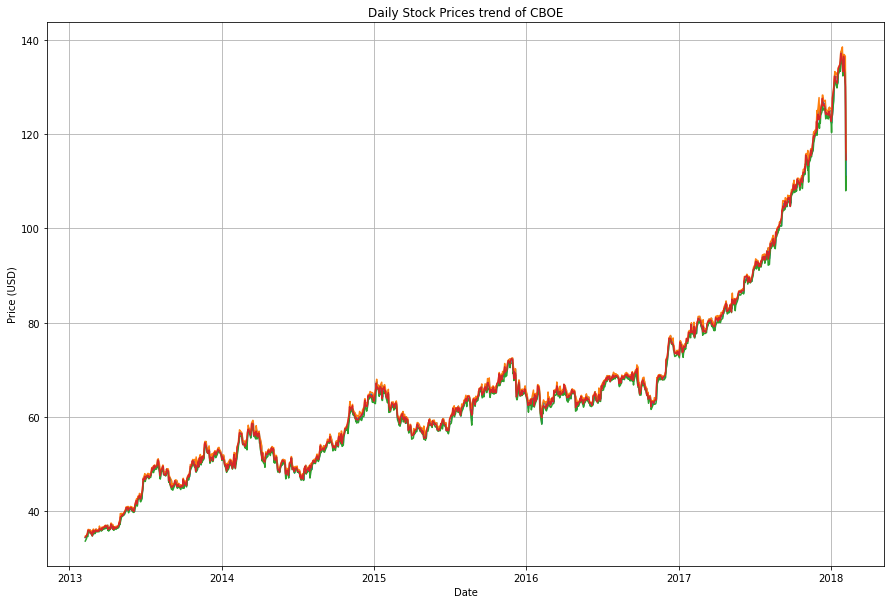

In [13]:
fig = plt.figure(figsize=(15,10))
finance.plot_trend(cboe.iloc[:,:-1])

We will now try to predict the "close" price in the rest of this analysis.
To predict the "close" price of CBOE, first we will need a dataframe with the "close" price of all stocks, with that column of CBOE in the front, and a column of dates.

In [14]:
# Create a dataframe of all the "close" prices called "tdf"
tdf = finance.dataframe_by_price_type("close")
# To deal with missing values, all the stocks with nan values are dropped  
tdf.dropna(axis=1, inplace=True)  
# Rearrange the dataframe
tdf_col = list(tdf.columns)
new_col = []
new_col.append(tdf_col.pop(tdf_col.index("date")))
new_col.append(tdf_col.pop(tdf_col.index("close_CBOE")))
new_col += tdf_col
tdf = tdf[new_col]

In [15]:
# Now look at how the dataframe looks like
print(tdf.head())

         date  close_CBOE  close_AFL  close_ALL  close_AXP  close_AIG  \
0  2013-02-08       34.46      50.35      45.14      61.80      38.79   
1  2013-02-11       34.78      50.26      45.25      61.98      39.45   
2  2013-02-12       34.96      49.50      45.61      62.20      38.63   
3  2013-02-13       34.99      48.65      45.88      62.10      38.87   
4  2013-02-14       35.69      48.83      45.88      62.34      39.21   

   close_AMP  close_AON  close_AJG  close_AIZ  ...  close_RJF  close_RF  \
0      66.49      56.53      37.97      38.56  ...      45.31      7.93   
1      66.49      56.66      37.88      38.48  ...      45.32      7.94   
2      67.49      56.70      37.82      41.05  ...      45.41      7.93   
3      67.89      57.28      38.54      41.39  ...      45.58      7.85   
4      69.04      57.30      38.82      42.01  ...      45.60      7.91   

   close_SPGI  close_STT  close_TROW  close_TRV  close_USB  close_UNM  \
0       42.67      56.55       73.27 

Since the is a time series, including the dates as a variable would be inappropriate. However the date may have impact on the stock prices. To take care of this, one hot encoding is used and five binary variables are created to represent Monday to Friday. If it is Monday, the "Mon" varaible will be 1, else will be 0.

In [16]:
wday = pd.DataFrame(pd.to_datetime(cboe["date"].copy(deep=True)))
days = ["Mon", "Tue", "Wed", "Thu", "Fri"]
for i in range(len(days)):
    wday[days[i]] = wday["date"].apply(lambda x: 1 if x.weekday() == i else 0)
wday.drop("date", axis=1, inplace=True)
tdf = tdf.iloc[:,:2].join(wday.join(tdf.iloc[:,2:]))

In [17]:
# Now look at how the new dataframe looks like
print(tdf.head())

         date  close_CBOE  Mon  Tue  Wed  Thu  Fri  close_AFL  close_ALL  \
0  2013-02-08       34.46    0    0    0    0    1      50.35      45.14   
1  2013-02-11       34.78    1    0    0    0    0      50.26      45.25   
2  2013-02-12       34.96    0    1    0    0    0      49.50      45.61   
3  2013-02-13       34.99    0    0    1    0    0      48.65      45.88   
4  2013-02-14       35.69    0    0    0    1    0      48.83      45.88   

   close_AXP  ...  close_RJF  close_RF  close_SPGI  close_STT  close_TROW  \
0      61.80  ...      45.31      7.93       42.67      56.55       73.27   
1      61.98  ...      45.32      7.94       44.28      56.60       73.13   
2      62.20  ...      45.41      7.93       44.03      56.93       73.75   
3      62.10  ...      45.58      7.85       44.33      57.07       74.21   
4      62.34  ...      45.60      7.91       44.86      57.20       73.84   

   close_TRV  close_USB  close_UNM  close_WFC  close_ZION  
0      78.86      33

It seems now the dataframe for the analysis is ready. Now a class "Dataset" is created, the purpose of which is to generate a new dataframe containing the lagged price of the stocks. The lag is a hyperparameter to be specified upon the instanization.
More specifically, if the lag is 3, the row of day 4 will contain columns of the stock prices of day 1, day 2 and day 3. 

In other words, columns "close_{stock}_1", "close_{stock}_2", "close_{stock}_3" responsible for the past 3 day prices will be created for stock = {stock}.

In [18]:
# Create a class "Dataset" that creates a dataframe for the data analysis
class Dataset:
    def __init__(self, df, lag):
        self.lag = lag
        self.df = df
        self.names = list(df.columns[7:])
        self.dates = df.iloc[:,0].copy(deep=True)

    # Generate the independent dataframe
    def gen_x(self):
        self.x_df = self.df.iloc[:,7:].copy(deep=True)
        for name in self.names:
            for k in range(1, self.lag + 1):
                self.x_df[name + "_" + str(k)] = np.zeros(self.x_df.shape[0])
        i = self.lag
        while i <= self.x_df.shape[0]:
            for name in self.names:
                for k in range(1, self.lag + 1):
                    self.x_df[name + "_" + str(k)][i] = self.x_df[name][i - k]
            i += 1
        for name in self.names:
            self.x_df.drop(name, axis=1, inplace=True)
        self.x_df = wday.join(self.x_df)

    # Generate the dependent dataframe
    def gen_y(self):
        self.y_df = self.df.iloc[:,1].copy(deep=True)

    # Split the dataframe into training and testing parts
    def train_test_split(self, n_split=0.8):
        self.n = int(self.x_df.shape[0] * n_split)
        self.x_train = self.x_df[self.lag:self.n]
        self.x_test = self.x_df[self.n:]
        self.y_train = self.y_df[self.lag:self.n]
        self.y_test = self.y_df[self.n:]
        return self.x_train, self.y_train, self.x_test, self.y_test

    # Plot the predicted data and the real data
    def plot_performance(self, y_pred):
        y_series = pd.Series(list(self.y_df), index = self.dates)
        y_predict = y_series[self.lag:self.n].append(pd.Series(y_pred, index=self.dates[self.n:]))
        mse = mean_squared_error(y_test, y_pred)
        plt.plot(y_predict, "r", label = "Predicted Data")
        plt.plot(y_series, "b", label = "Real Data")
        plt.axvline(x=self.dates[self.n], linestyle="dashed", label="Prediction starts")
        plt.xlabel("Date")
        plt.ylabel("Price (USD)")
        plt.title("Predicted Data versus Real Data, MSE = {mse}".format(mse = mse))
        plt.legend()
        plt.show()

In [19]:
# Create a dataset for the analysis with lag 2
dataset = Dataset(tdf, 2)
# Generate the independent and dependent dataset
dataset.gen_x()
dataset.gen_y()
x_train, y_train, x_test, y_test = dataset.train_test_split()

The training data with lag 2 looks like below.
Row 2 is the day 3 (Since the index starts from 0), which is a Tuesday, "close_AFL_1" and "close_AFL_2" are the prices of day 2 and day 1 respectively.

In [20]:
print(x_train.head())
print(y_train.head())

   Mon  Tue  Wed  Thu  Fri  close_AFL_1  close_AFL_2  close_ALL_1  \
2    0    1    0    0    0        50.26        50.35        45.25   
3    0    0    1    0    0        49.50        50.26        45.61   
4    0    0    0    1    0        48.65        49.50        45.88   
5    0    0    0    0    1        48.83        48.65        45.88   
6    0    1    0    0    0        49.34        48.83        45.85   

   close_ALL_2  close_AXP_1  ...  close_TRV_1  close_TRV_2  close_USB_1  \
2        45.14        61.98  ...        79.21        78.86        34.09   
3        45.25        62.20  ...        79.90        79.21        34.31   
4        45.61        62.10  ...        79.99        79.90        33.93   
5        45.88        62.34  ...        80.34        79.99        33.99   
6        45.88        61.69  ...        80.39        80.34        33.91   

   close_USB_2  close_UNM_1  close_UNM_2  close_WFC_1  close_WFC_2  \
2        33.65        24.17        24.06        35.26        34.

Now a function plot_cv is created, which will create 4 dataframes with lags 1, 2, 3 and 4. It will then fit in the model with the data and make cross validation prediction.The other function plot_test will plot the testing set prediction.

The first 80% days in the training set will be used for training while the next 20% days will be used for cross validation.
Mean squared error will be used as the loss metrics in this entire analysis

In [21]:
def plot_cv(model, df):
    lags = [1, 2, 3, 4]
    fig = plt.figure(figsize=(28, 20))
    for i in range(4):
        dataset = Dataset(df, lags[i])
        dataset.gen_x()
        dataset.gen_y()
        x_train, y_train, x_test, y_test = dataset.train_test_split()
        cv = int(y_train.shape[0] * 0.8)
        end = int(y_train.shape[0])
        model_reg = model
        model_reg.fit(x_train[:cv], y_train[:cv])
        y_pred = model_reg.predict(x_train[cv:])
        y_series = pd.Series(list(dataset.y_df[:end]), index=dataset.dates[:end])
        y_predict = y_series[dataset.lag:cv].append(pd.Series(y_pred, index=dataset.dates[cv:end]))
        mse = mean_squared_error(y_train[cv:], y_pred)
        ax = fig.add_subplot(2, 2, i + 1)
        ax.plot(y_predict, "r", label="Predicted Data")
        ax.plot(y_series, "b", label="Real Data")
        ax.axvline(x=dataset.dates[cv], linestyle="dashed", label="Cross validation starts")
        ax.title.set_text("Using lag {lag} and results in MSE: {mse}".format(lag=lags[i], mse=mse))
        ax.legend()
    plt.show()
    
def plot_test(model, df):
    lags = [1, 2, 3, 4]
    fig = plt.figure(figsize=(28, 20))
    for i in range(len(lags)):
        dataset = Dataset(df, lags[i])
        dataset.gen_x()
        dataset.gen_y()
        x_train, y_train, x_test, y_test = dataset.train_test_split()
        model_reg = model
        cv = int(y_train.shape[0] * 0.8)
        model_reg.fit(x_train[:cv],y_train[:cv])
        y_pred = model_reg.predict(x_test)
        y_series = pd.Series(list(dataset.y_df), index=dataset.dates)
        y_predict = y_series[dataset.lag:dataset.n].append(pd.Series(y_pred, index=dataset.dates[dataset.n:]))    
        mse = mean_squared_error(y_test, y_pred)
        ax = fig.add_subplot(2, 2, i + 1)
        ax.plot(y_predict, "r", label="Predicted Data")
        ax.plot(y_series, "b", label="Real Data")
        ax.axvline(x=dataset.dates[dataset.n], linestyle="dashed", label="Prediction starts")
        ax.title.set_text("Using lag {lag} and results in MSE: {mse}".format(lag=lags[i], mse=mse))
        ax.legend()
plt.show()

In this prediction, linear regression and mean squared error are used as the regressor and the loss metrics respectively.

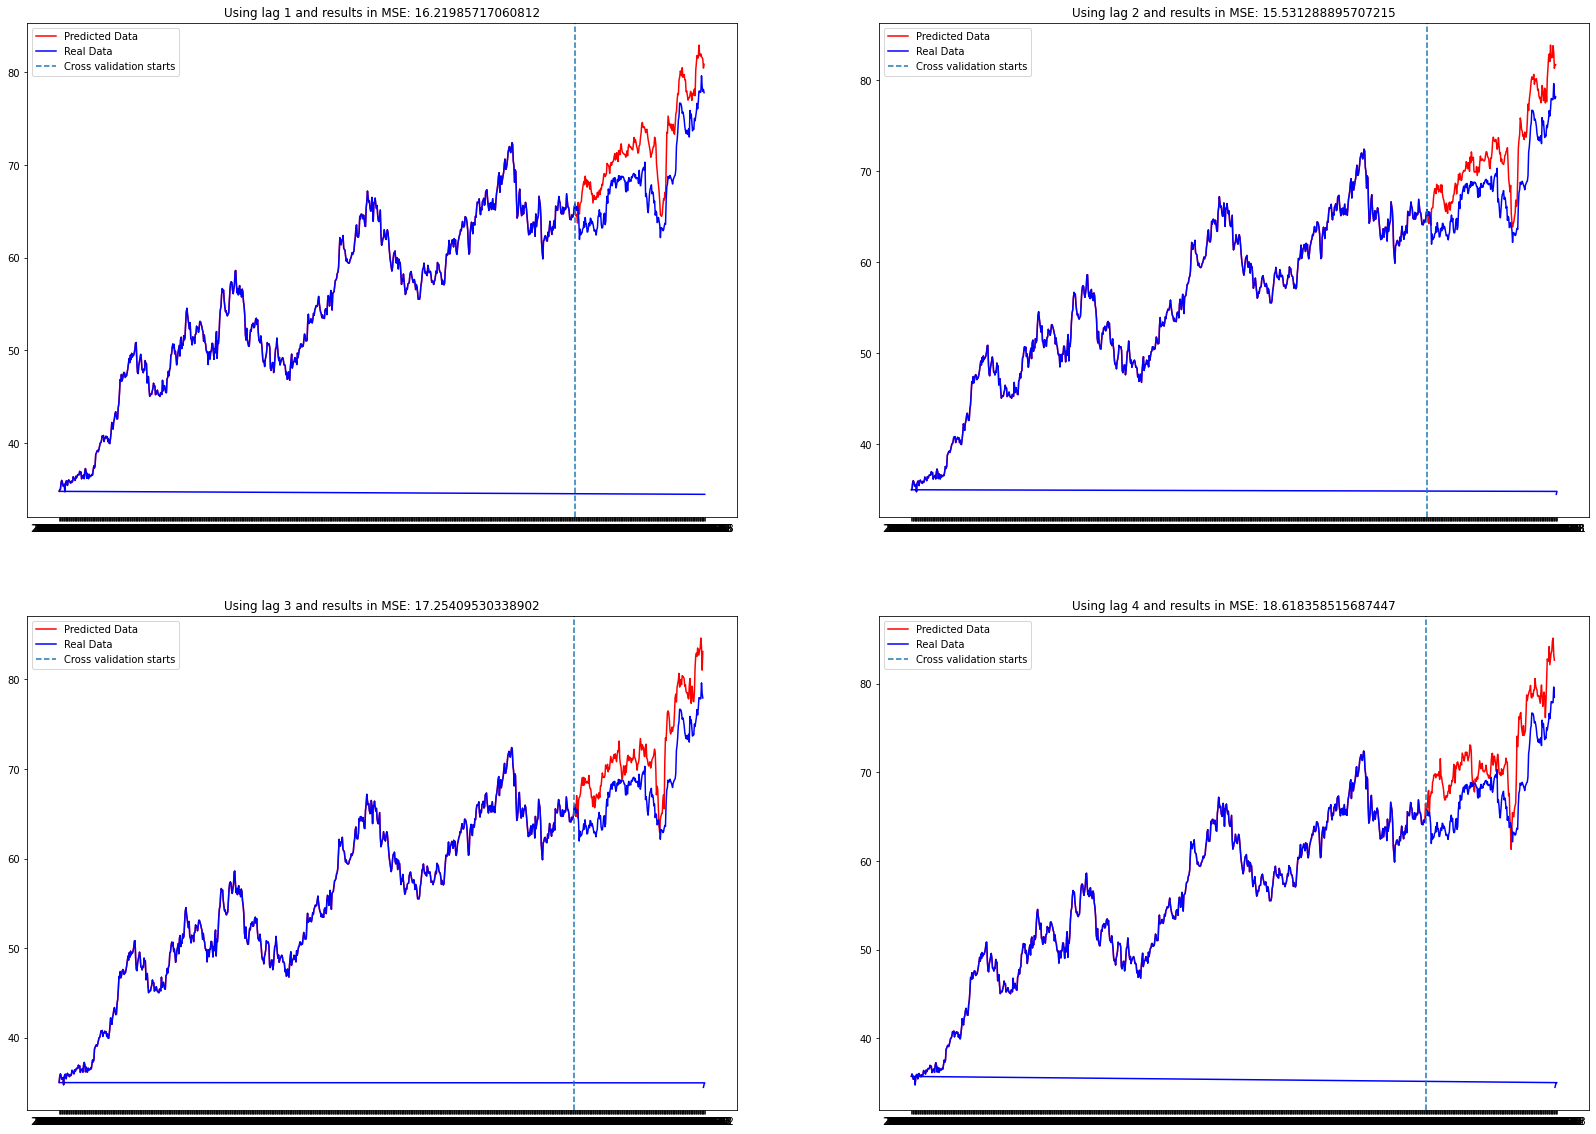

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
# lin_reg = LinearRegression(fit_intercept=False)
plot_cv(LinearRegression(fit_intercept=False), tdf)

It seems the results of using different lags are quite similar in the validation set.
We then look at how they perform in the test set.

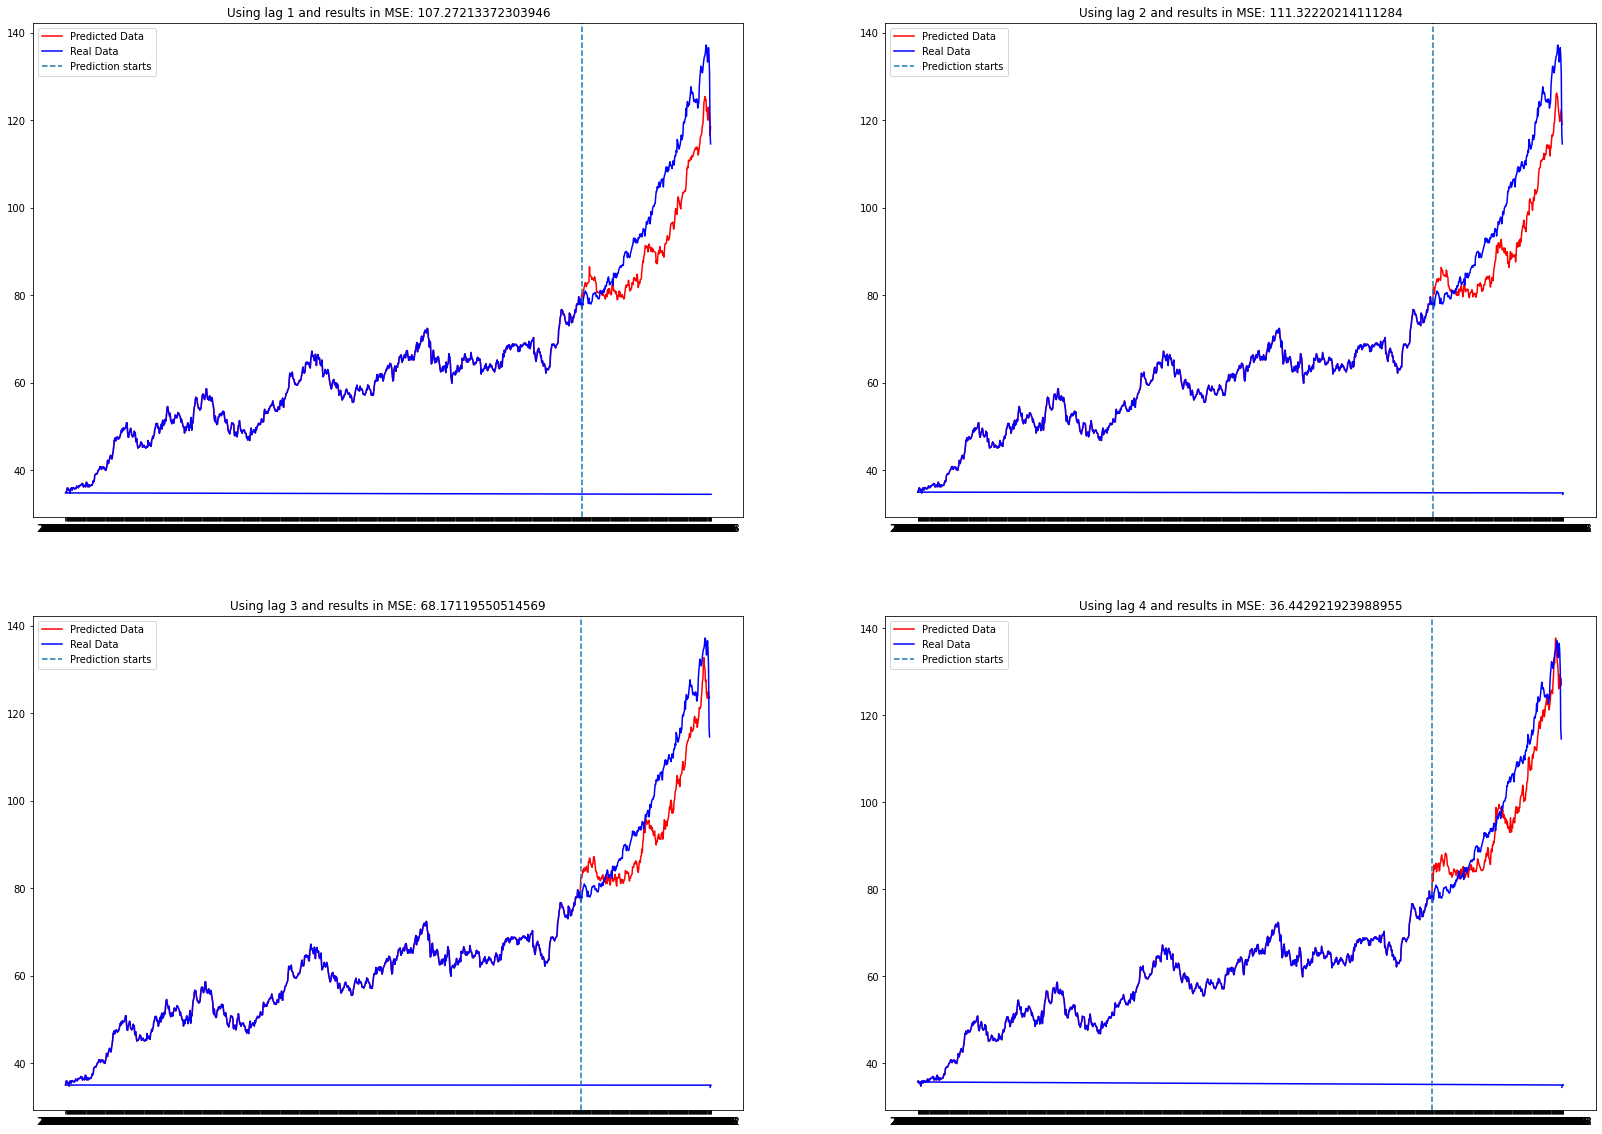

In [23]:
plot_test(LinearRegression(fit_intercept=False), tdf)

It seems the model using lag 4 has not bad performance in both the cross validation and testing set.
We then look at the overall fitting of the model in the training set.

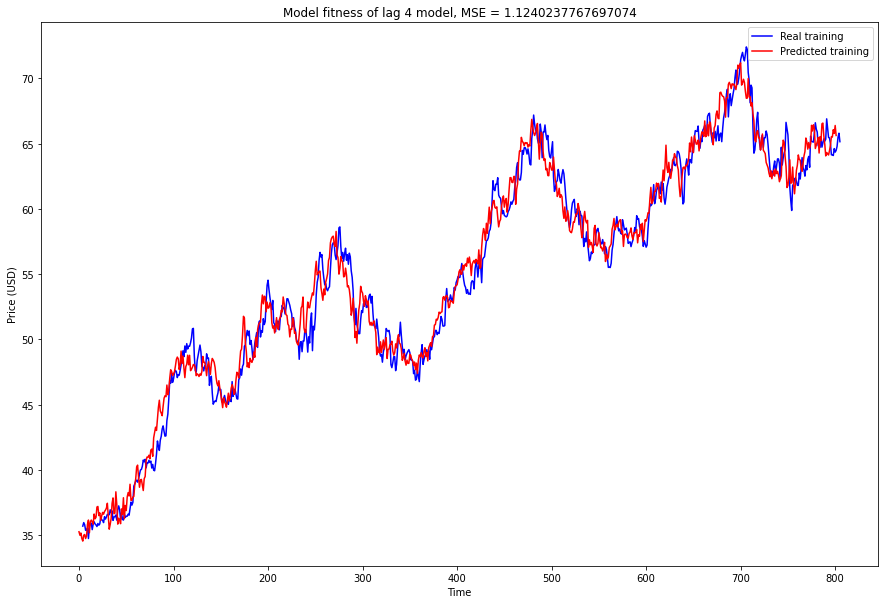

In [24]:
# Predict the training data using the trained model
dataset = Dataset(tdf, 4)
dataset.gen_x()
dataset.gen_y()
x_train, y_train, x_test, y_test = dataset.train_test_split()
lin_reg = LinearRegression(fit_intercept=False)
cv = int(y_train.shape[0] * 0.8)
end = int(y_train.shape[0])
lin_reg.fit(x_train[:cv], y_train[:cv])
y_train_pred = lin_reg.predict(x_train[:cv])
# Plot to see the fitting of the model
mse = mean_squared_error(y_train[:cv], y_train_pred)
fig = plt.figure(figsize=(15,10))
plt.plot(y_train[:cv], "b", label = "Real training")
plt.plot(y_train_pred, "r", label = "Predicted training")
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.title("Model fitness of lag 4 model, MSE = {mse}".format(mse = mse))
plt.legend()
plt.show()

Then Decision tree regressor is tried.
They obtain generally lower MSE compared to linear model, but they just look terrible.

Perhaps decision tree may just not be suitable to regress highly fluctuating data like this.

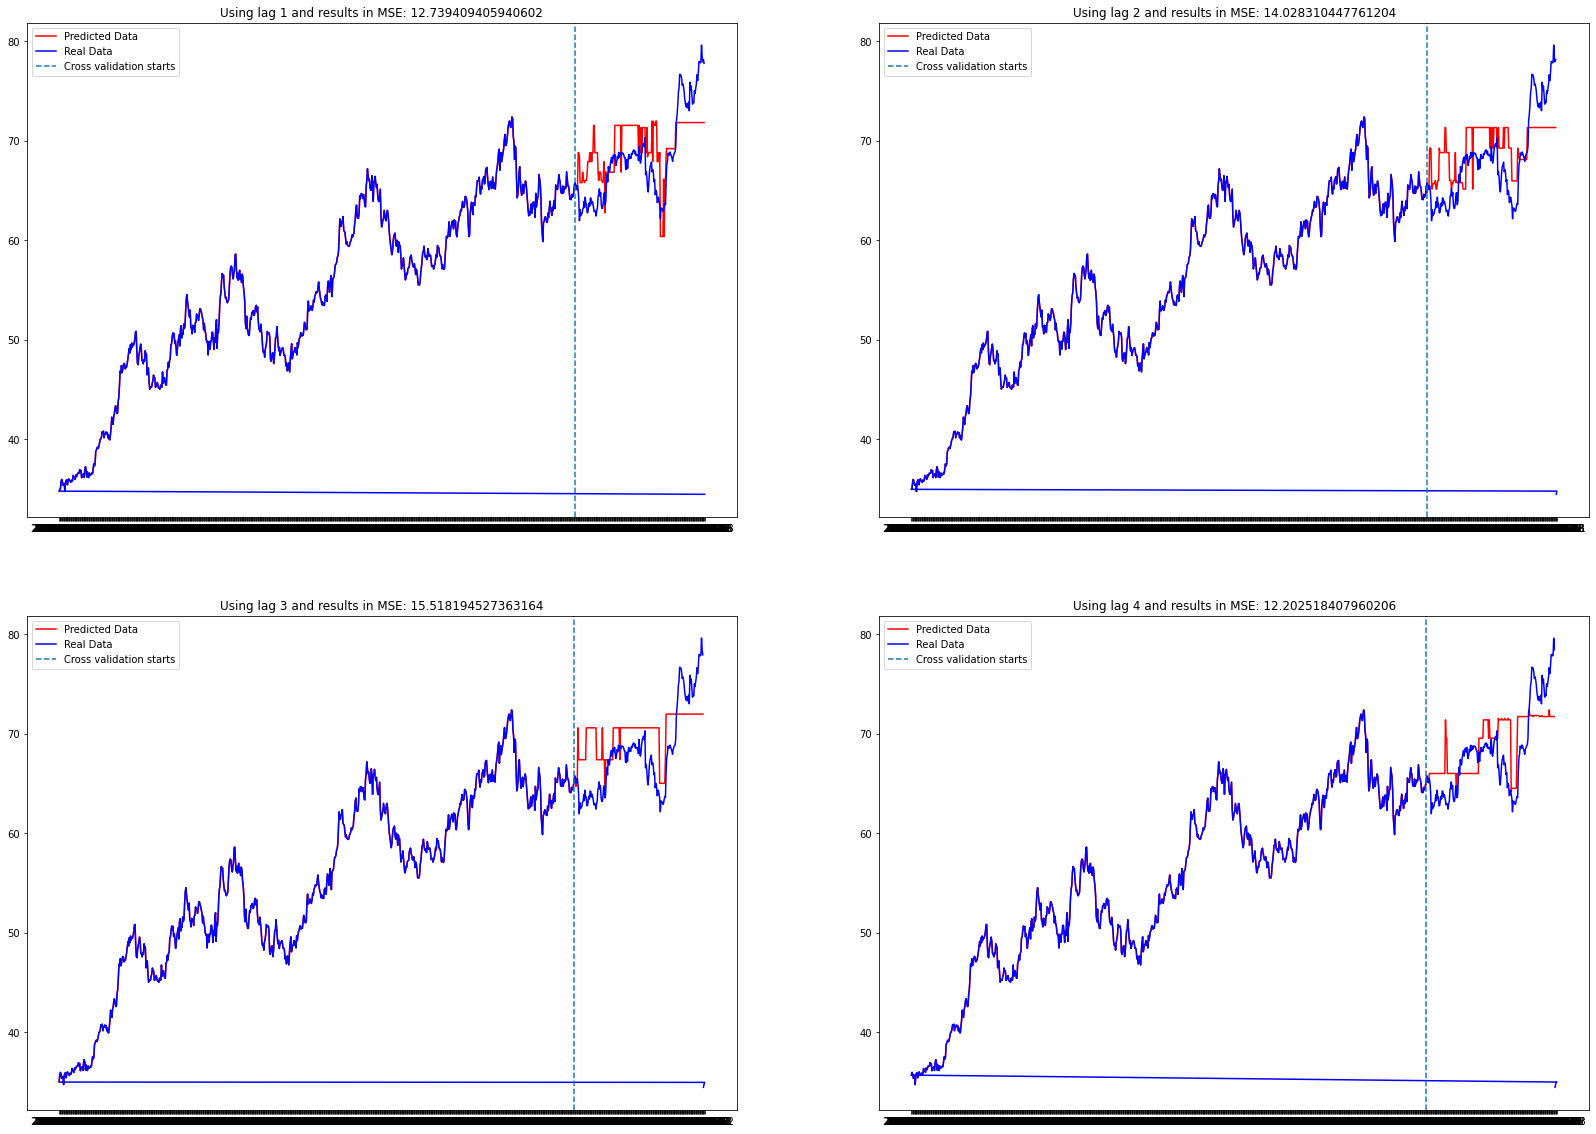

In [26]:
from sklearn.tree import DecisionTreeRegressor
plot_cv(DecisionTreeRegressor(), tdf)

Considered that the linear model produced earlier may have overfitted the data, and that some lags variable may be redundant and not contribute much to the prediction.

Regularization is tried here to curb this problem, and the LASSO term is introduced into the model. Since it has the ability to set the weight of redundant features to zero, the largest dataset (lag 4) with the most information is used.

c:\users\horch\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 605.1864284338819, tolerance: 6.318115286943141
  model = cd_fast.enet_coordinate_descent(
c:\users\horch\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 729.3466979619174, tolerance: 6.318115286943141
  model = cd_fast.enet_coordinate_descent(
c:\users\horch\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 588.3851177090182, tolerance: 6.318115286943141
  model = cd_fast.enet_coordinate_descent(
c:\users\horc

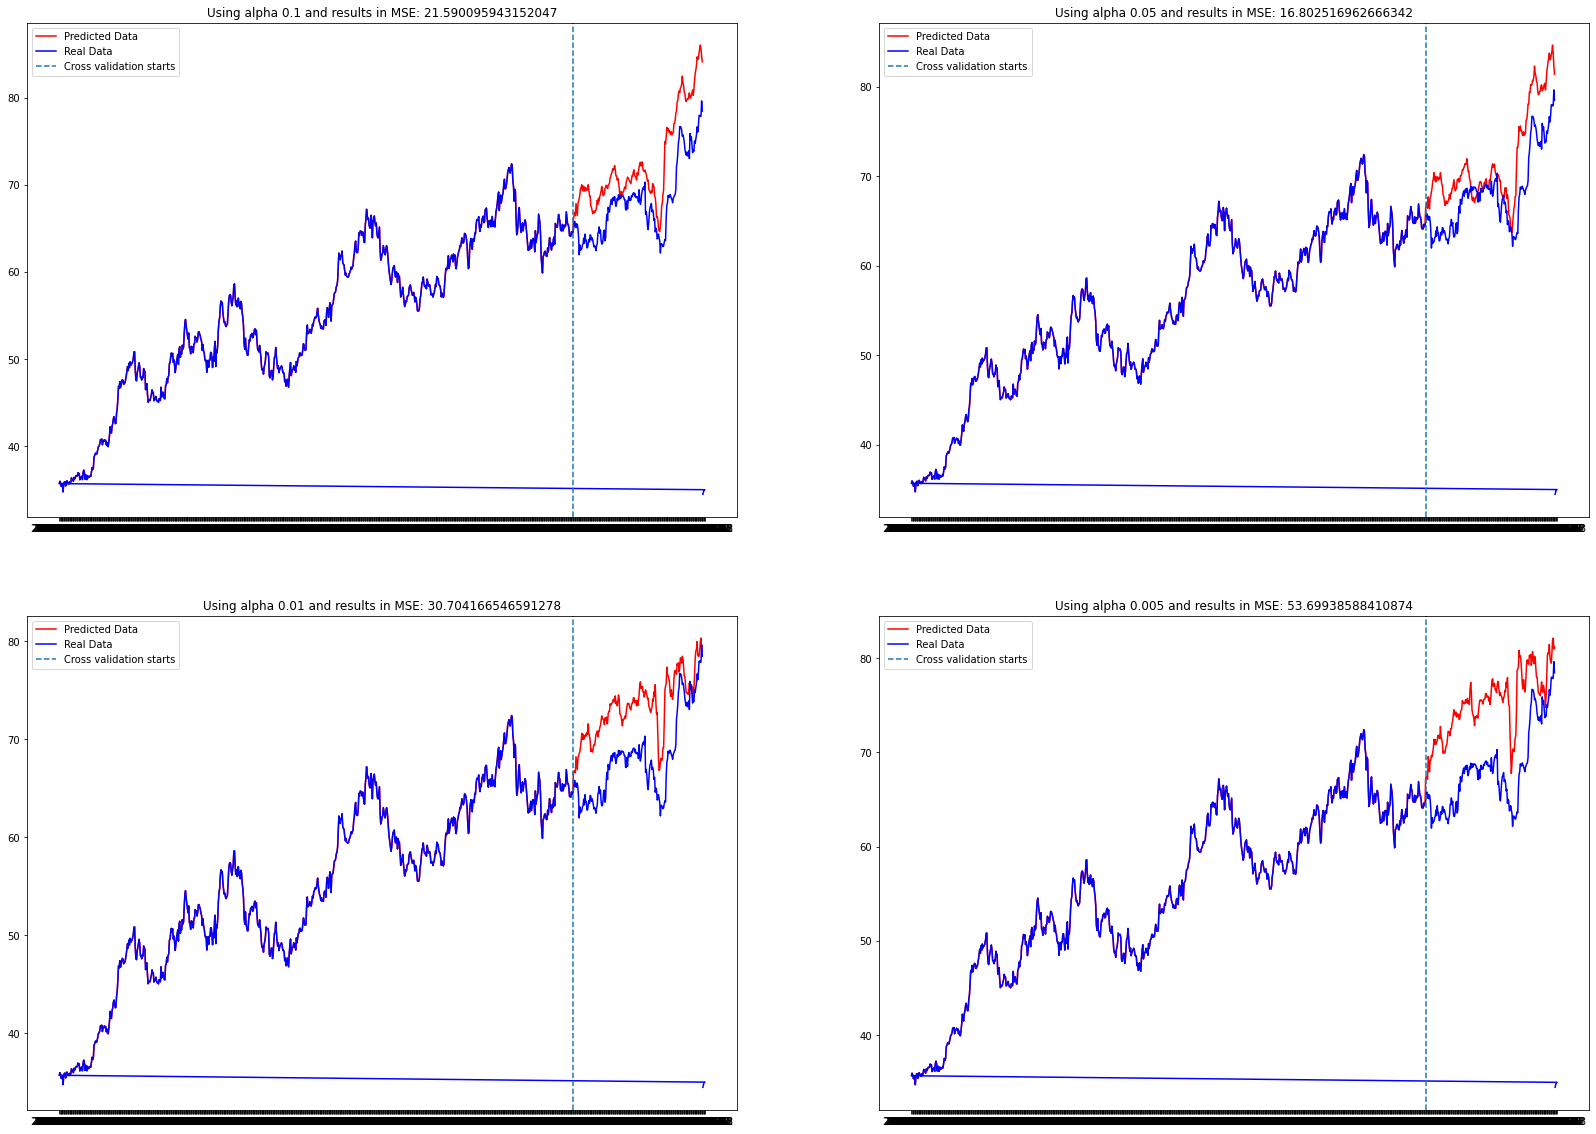

In [56]:
from sklearn.linear_model import Lasso
# Create the lag 4 dataset
dataset = Dataset(tdf, 4)
dataset.gen_x()
dataset.gen_y()
x_train, y_train, x_test, y_test = dataset.train_test_split()
# Define a list of alpha parameters to be tried for the lasso term
alphas = [0.1, 0.05, 0.01, 0.005]
fig = plt.figure(figsize=(28, 20))
for i in range(len(alphas)):
    lasso_reg = Lasso(alpha=alphas[i])
    cv = int(y_train.shape[0] * 0.8)
    end = int(y_train.shape[0])
    lasso_reg.fit(x_train[:cv],y_train[:cv])
    y_pred = lasso_reg.predict(x_train[cv:])
    y_series = pd.Series(list(dataset.y_df[:end]), index=dataset.dates[:end])
    y_predict = y_series[dataset.lag:cv].append(pd.Series(y_pred, index=dataset.dates[cv:end]))    
    mse = mean_squared_error(y_train[cv:], y_pred)
    ax = fig.add_subplot(2, 2, i + 1)
    ax.plot(y_predict, "r", label="Predicted Data")
    ax.plot(y_series, "b", label="Real Data")
    ax.axvline(x=dataset.dates[cv], linestyle="dashed", label="Cross validation starts")
    ax.title.set_text("Using alpha {alpha} and results in MSE: {mse}".format(alpha=alphas[i], mse=mse))
    ax.legend()
plt.show()

In [51]:
print(len(dataset.dates[1003:]))

256


c:\users\horch\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 605.1864284338819, tolerance: 6.318115286943141
  model = cd_fast.enet_coordinate_descent(
c:\users\horch\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 729.3466979619174, tolerance: 6.318115286943141
  model = cd_fast.enet_coordinate_descent(
c:\users\horch\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 588.3851177090182, tolerance: 6.318115286943141
  model = cd_fast.enet_coordinate_descent(
c:\users\horc

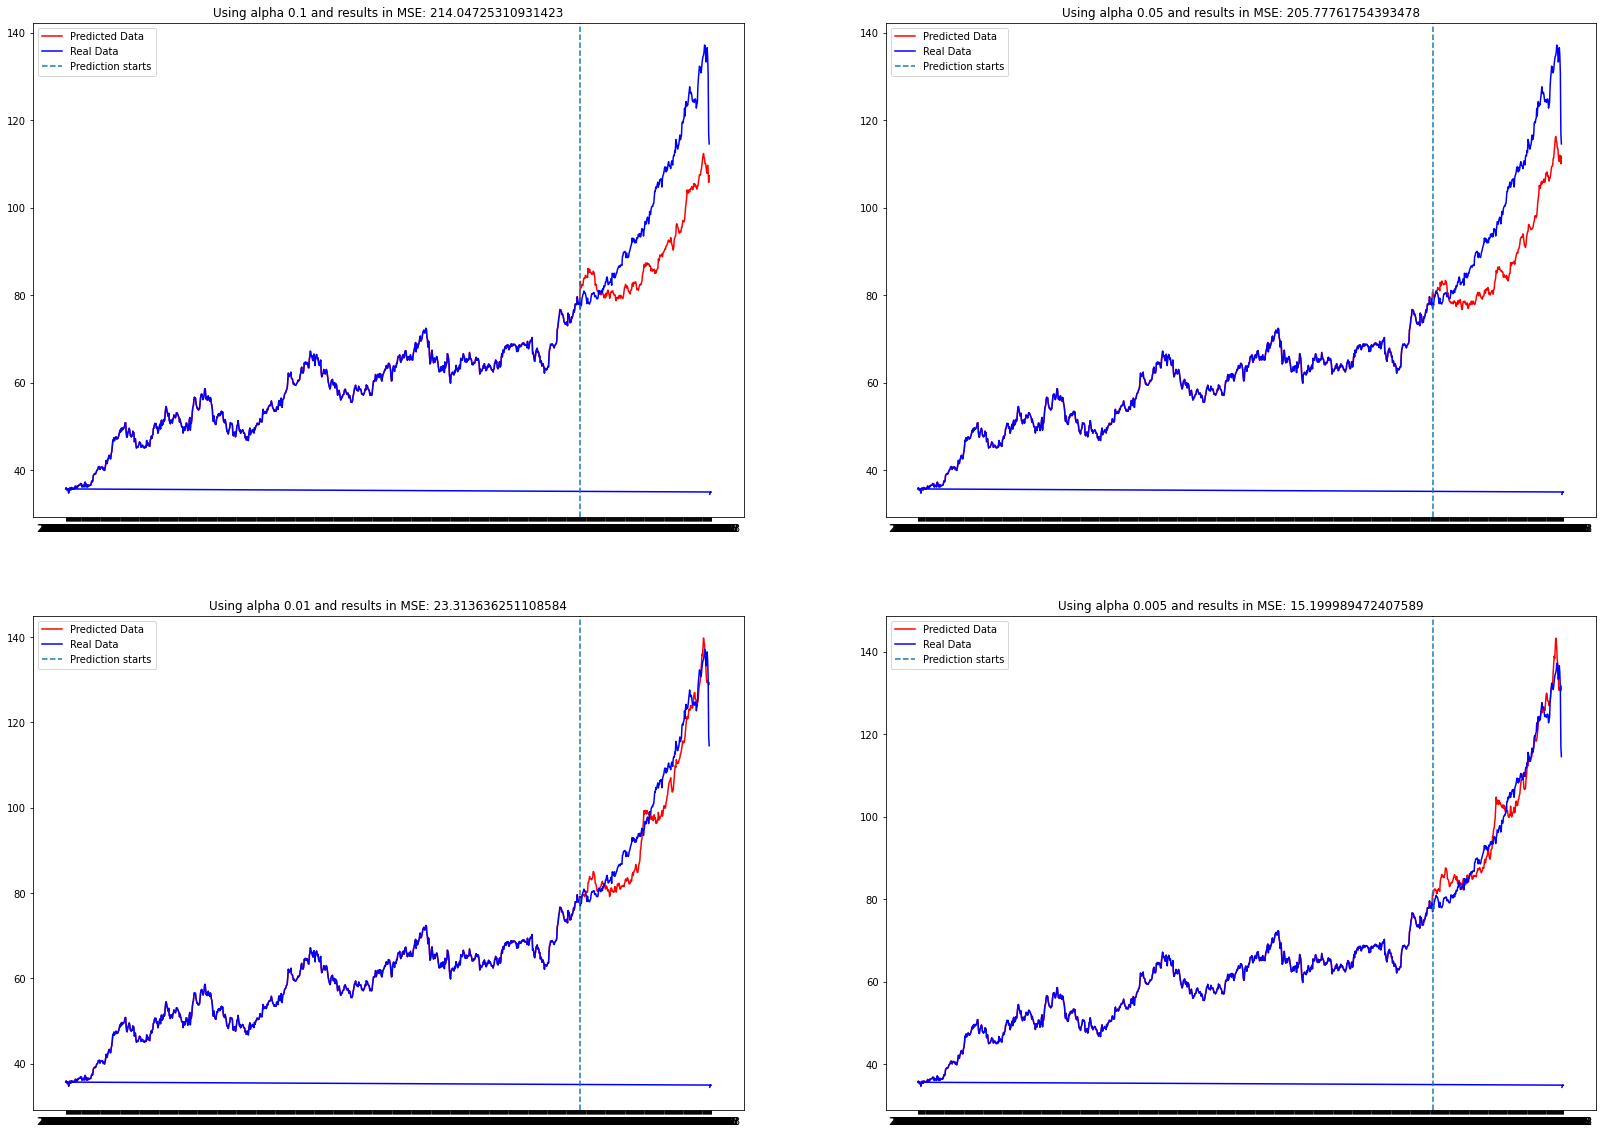

In [57]:
fig = plt.figure(figsize=(28, 20))
for i in range(len(alphas)):
    lasso_reg = Lasso(alpha=alphas[i])
    cv = int(y_train.shape[0] * 0.8)
    lasso_reg.fit(x_train[:cv],y_train[:cv])
    y_pred = lasso_reg.predict(x_test)
    y_series = pd.Series(list(dataset.y_df), index=dataset.dates)
    y_predict = y_series[dataset.lag:dataset.n].append(pd.Series(y_pred, index=dataset.dates[dataset.n:]))    
    mse = mean_squared_error(y_test, y_pred)
    ax = fig.add_subplot(2, 2, i + 1)
    ax.plot(y_predict, "r", label="Predicted Data")
    ax.plot(y_series, "b", label="Real Data")
    ax.axvline(x=dataset.dates[dataset.n], linestyle="dashed", label="Prediction starts")
    ax.title.set_text("Using alpha {alpha} and results in MSE: {mse}".format(alpha=alphas[i], mse=mse))
    ax.legend()
plt.show()

c:\users\horch\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 670.345202968502, tolerance: 6.428029932053732
  model = cd_fast.enet_coordinate_descent(
c:\users\horch\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 724.9241683951394, tolerance: 6.397961388053733
  model = cd_fast.enet_coordinate_descent(
c:\users\horch\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 735.2179974086212, tolerance: 6.358028112618678
  model = cd_fast.enet_coordinate_descent(
c:\users\horch

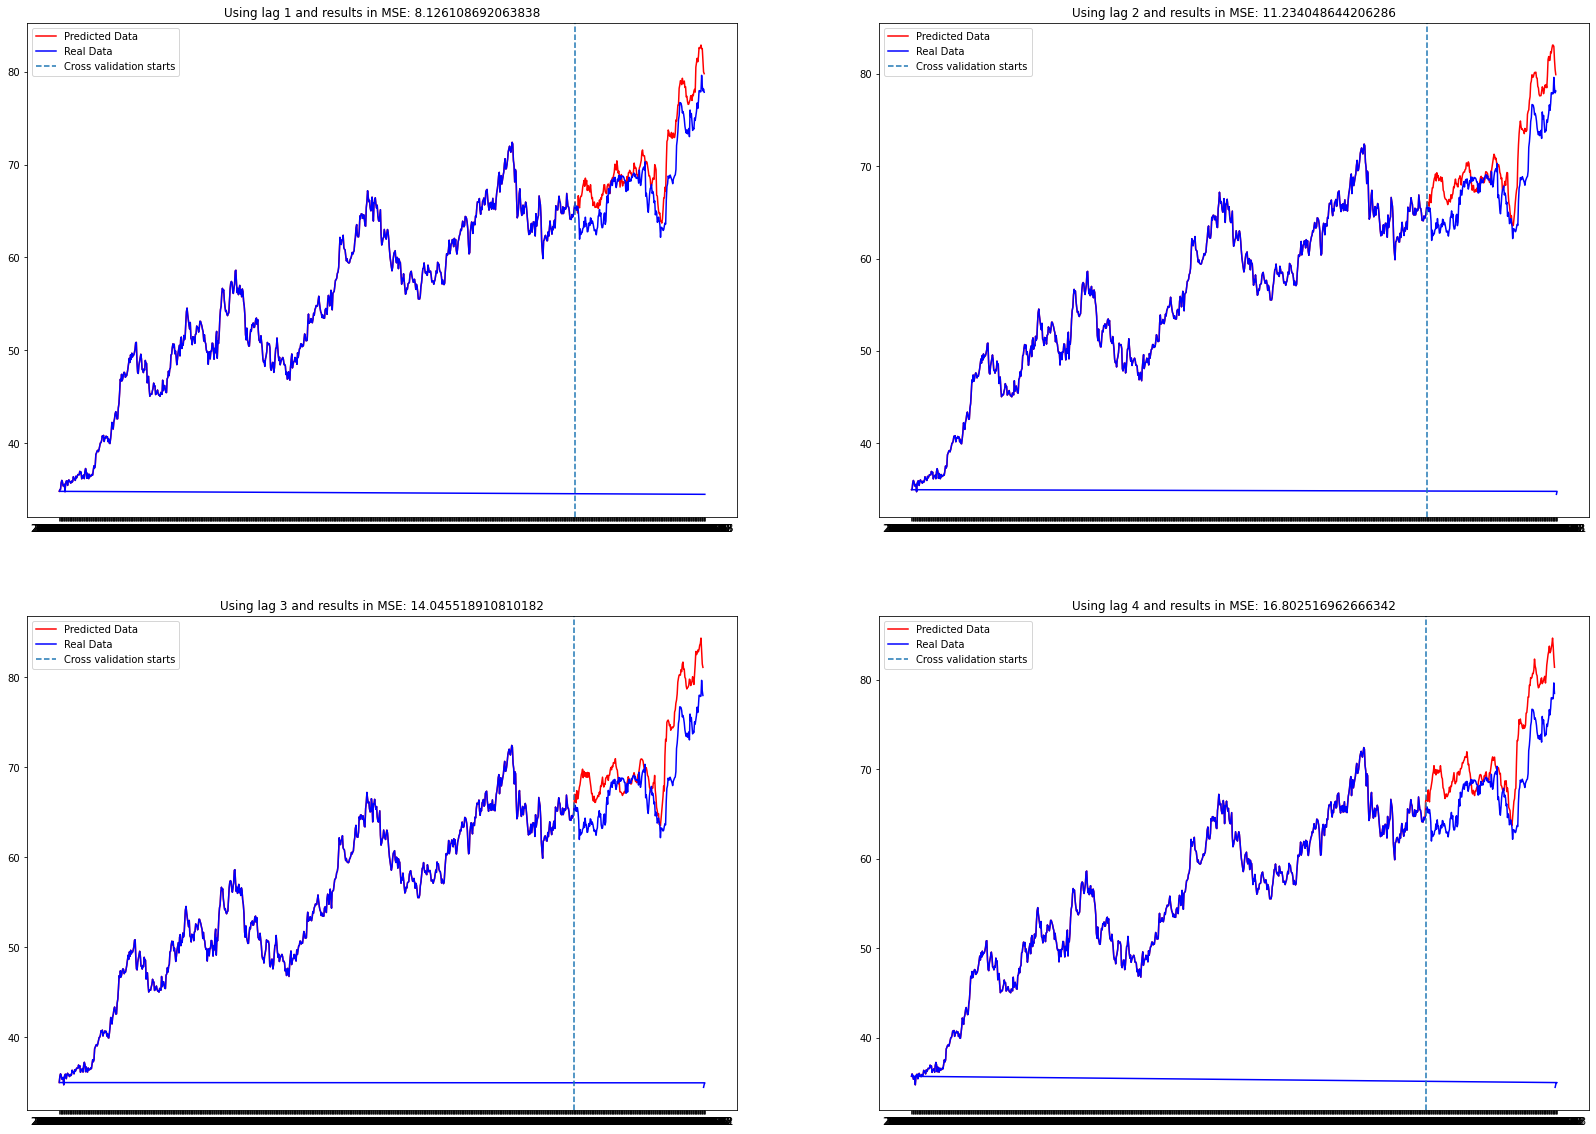

In [39]:
lasso_reg = Lasso(alpha=0.05)
plot_cv(lasso_reg)

c:\users\horch\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 670.345202968502, tolerance: 6.428029932053732
  model = cd_fast.enet_coordinate_descent(


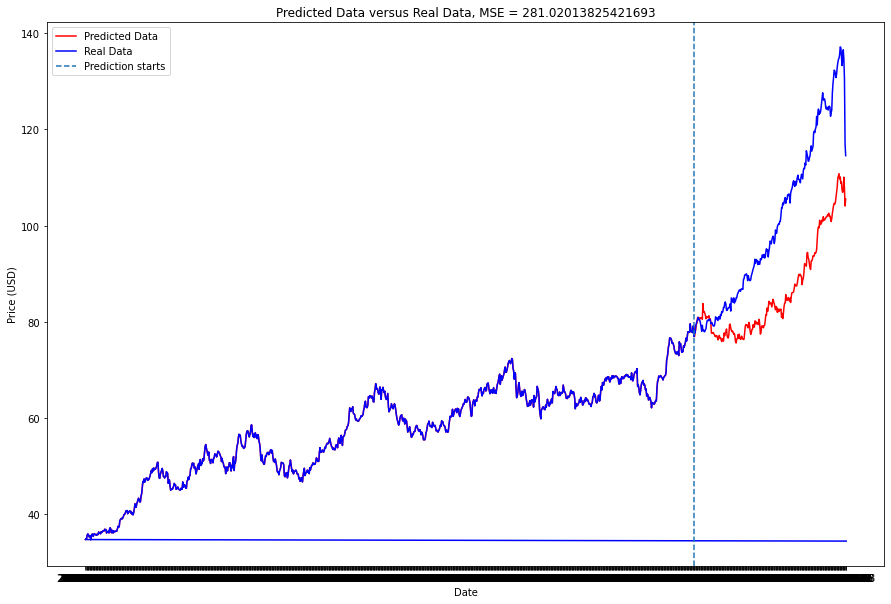

In [42]:
# Create a dataset for the analysis with lag 2
dataset = Dataset(tdf, 1)
dataset.gen_x()
dataset.gen_y()
x_train, y_train, x_test, y_test = dataset.train_test_split()
lasso_reg = Lasso(alpha=0.05)
cv = int(y_train.shape[0] * 0.8)
lasso_reg.fit(x_train[:cv], y_train[:cv])
# Predict the stock price of "CBOE" using the trained model
y_pred = lasso_reg.predict(x_test)
# Plot the predicted and the real data
fig = plt.figure(figsize=(15,10))
dataset.plot_performance(y_pred)

Having tried different regressors, it seems so far the best one is the Lasso one which adds a regularization term in the loss function to avoid overfitting. 

The one with the least alpha (alpha = 0.05) penalizes the least for overfitting. It performed not particularly well in the cross validation set, but turned out quite accurate in the test set. This may be partly explained by the fact that the cross validation data has an unclear fluctuating trend, while the test set is a pure increase. Therefore the models with high regularization are not able to follow the sharp increase in the test set and predict lower than the actual data.

Now we will try a different approach for the prediction. Instead of emphasizing on using different lags or model parameters, we focus on how the stocks features are selected in the initial step. This time rather than just including all the financial stocks, all stocks existed in both the datafile and the wikipedia table will be included. And among all the stocks included, only those which have a relationship/correlation with CBOE will be added to the feature dataframe for prediction.

In [22]:
# First import all stocks which exist both in the datafile and the wikitable
all_data = {}
for stock in list(snf_table.symbol):
    try:
        data_file = open("S&P500 Data/individual_stocks_5yr/individual_stocks_5yr/{name}_data.csv". \
                         format(name=stock), "r")
        all_data[stock] = pd.read_csv(data_file)
    except OSError:
        print("This file does not exist: ", stock + "_data.csv")

all_df = pd.DataFrame()
all_df["date"] = all_data[list(all_data.keys())[0]]["date"]
for stock in list(all_data.keys()):
    all_data[stock].drop(["date", "Name"], axis=1, inplace=True)
    all_data[stock].columns = [str(name) + "_" + str(stock) for name in list(all_data[stock].columns)]
    all_df = all_df.join(all_data[stock])

This file does not exist:  ABMD_data.csv
This file does not exist:  AMCR_data.csv
This file does not exist:  ANET_data.csv
This file does not exist:  ATO_data.csv
This file does not exist:  BKR_data.csv
This file does not exist:  BIO_data.csv
This file does not exist:  BKNG_data.csv
This file does not exist:  BR_data.csv
This file does not exist:  CARR_data.csv
This file does not exist:  CBRE_data.csv
This file does not exist:  CDW_data.csv
This file does not exist:  CE_data.csv
This file does not exist:  CPRT_data.csv
This file does not exist:  CTVA_data.csv
This file does not exist:  DXCM_data.csv
This file does not exist:  FANG_data.csv
This file does not exist:  DPZ_data.csv
This file does not exist:  DOW_data.csv
This file does not exist:  DD_data.csv
This file does not exist:  EVRG_data.csv
This file does not exist:  FRC_data.csv
This file does not exist:  FLT_data.csv
This file does not exist:  FTNT_data.csv
This file does not exist:  GL_data.csv
This file does not exist:  PEAK_

In [23]:
# Create a dataframe with date and all the close price of stocks
df = pd.DataFrame(all_df["date"].copy(deep=True))
for col_name in list(all_df.columns)[1:]:
    for name in ["close"]:
        if name in col_name:
            df = df.join(all_df[col_name])
            
# Drop all the columns with nan
df.dropna(axis=1, inplace=True) 
# Rearrange the dataframe
df_col = list(df.columns)
new_col = []
new_col.append(df_col.pop(df_col.index("date")))
new_col.append(df_col.pop(df_col.index("close_CBOE")))
new_col += df_col
new_tdf = df[new_col]

The way a stock is considered correlated to CBOE is by looking at their price difference. A new column for each stock excluding CBOE is created, which captures the price difference between that stock and CBOE throughout the entire time series.

Then the Augmented Dicky Fuller test is used to determine if the price difference is constant. If so, then the stock will be considered correlated to CBOE and will be included in the feature dataframe as a feature. Also in this test part, only the training period is considered.

c:\users\horch\appdata\local\programs\python\python38\lib\site-packages\statsmodels\regression\linear_model.py:889: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
c:\users\horch\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse


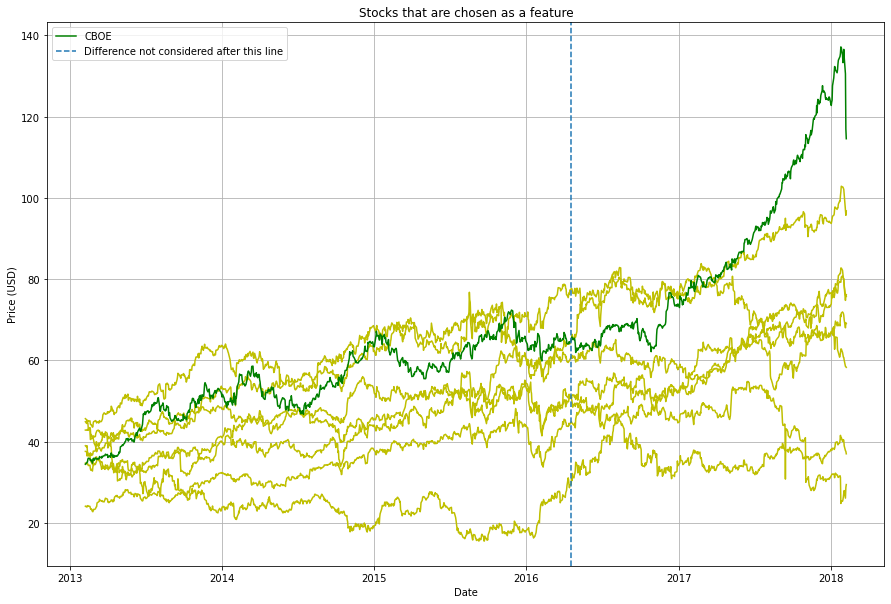

In [24]:
# n defines the index of the training period
n = 802
diff_df = df[["date", "close_CBOE"]][:802].copy(deep=True)
# Create a price difference column for each stocks other than CBOE
for name in list(df.columns[2:]):
    diff_df[str("diff") + str(name[5:])] = df[name][:802] - diff_df["close_CBOE"][:1007]

from statsmodels.tsa.stattools import adfuller
# Create a dataframe which captures the result of the test
adf_stat = pd.DataFrame(np.zeros((len(diff_df.columns[2:]), 2)), index = list(diff_df.columns[2:]), columns = ["Statistic", "p_value"])
for name in list(diff_df.columns[2:]):
    adf_stat["Statistic"][str(name)] = adfuller(diff_df[name])[0]
    adf_stat["p_value"][str(name)] = adfuller(diff_df[name])[1]

# Only the stocks with "quite negative" Statistic and significantly small p_value are considered, otherwise dropped
adf_filtered = adf_stat[adf_stat["Statistic"] < -3].copy(deep=True)
adf_filtered = adf_filtered[adf_filtered["p_value"] < 0.05]

# Name of the chosen stocks
dependent_stock_names = ["close_" + name[5:] for name in adf_filtered.index]

# Drop all the non-chosen stocks
new_tdf_1 = new_tdf.copy(deep=True)
for stock in list(new_tdf_1.columns[2:]):
    if stock not in dependent_stock_names:
        new_tdf_1.drop(stock, axis=1, inplace=True)

# Plot the dataframe of the chosen stocks
fig = plt.figure(figsize=(15,10))
plt.plot(pd.to_datetime(new_tdf_1.iloc[:,0]), new_tdf_1.iloc[:,2:], "y")
plt.plot(pd.to_datetime(new_tdf_1.iloc[:,0]), new_tdf_1.iloc[:,1], "g", label="CBOE")
plt.plot([],[],"y", label="Chosen stocks")
plt.axvline(x=pd.to_datetime(new_tdf_1.iloc[:,0])[802], linestyle="dashed", label="Difference not considered after this line")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.title("Stocks that are chosen as a feature")
plt.legend()
plt.grid()
plt.show()

# Add the binary weekday variables into the dataframe
newttdf = new_tdf_1.iloc[:,:2].join(wday.join(new_tdf_1.iloc[:,2:]))
new_tdf_1 = newttdf

From the graph above, we can see that most of the chosen stocks generally follow a similar trend to CBOE, but only before 2017, which is unfortunately our training set. Then CBOE rises sharp and has a more rocket like trend compared to the rest of the stocks after early 2017. 

As a result, we can already expect the model will not work well in the validation set which is after the blue dashed line.

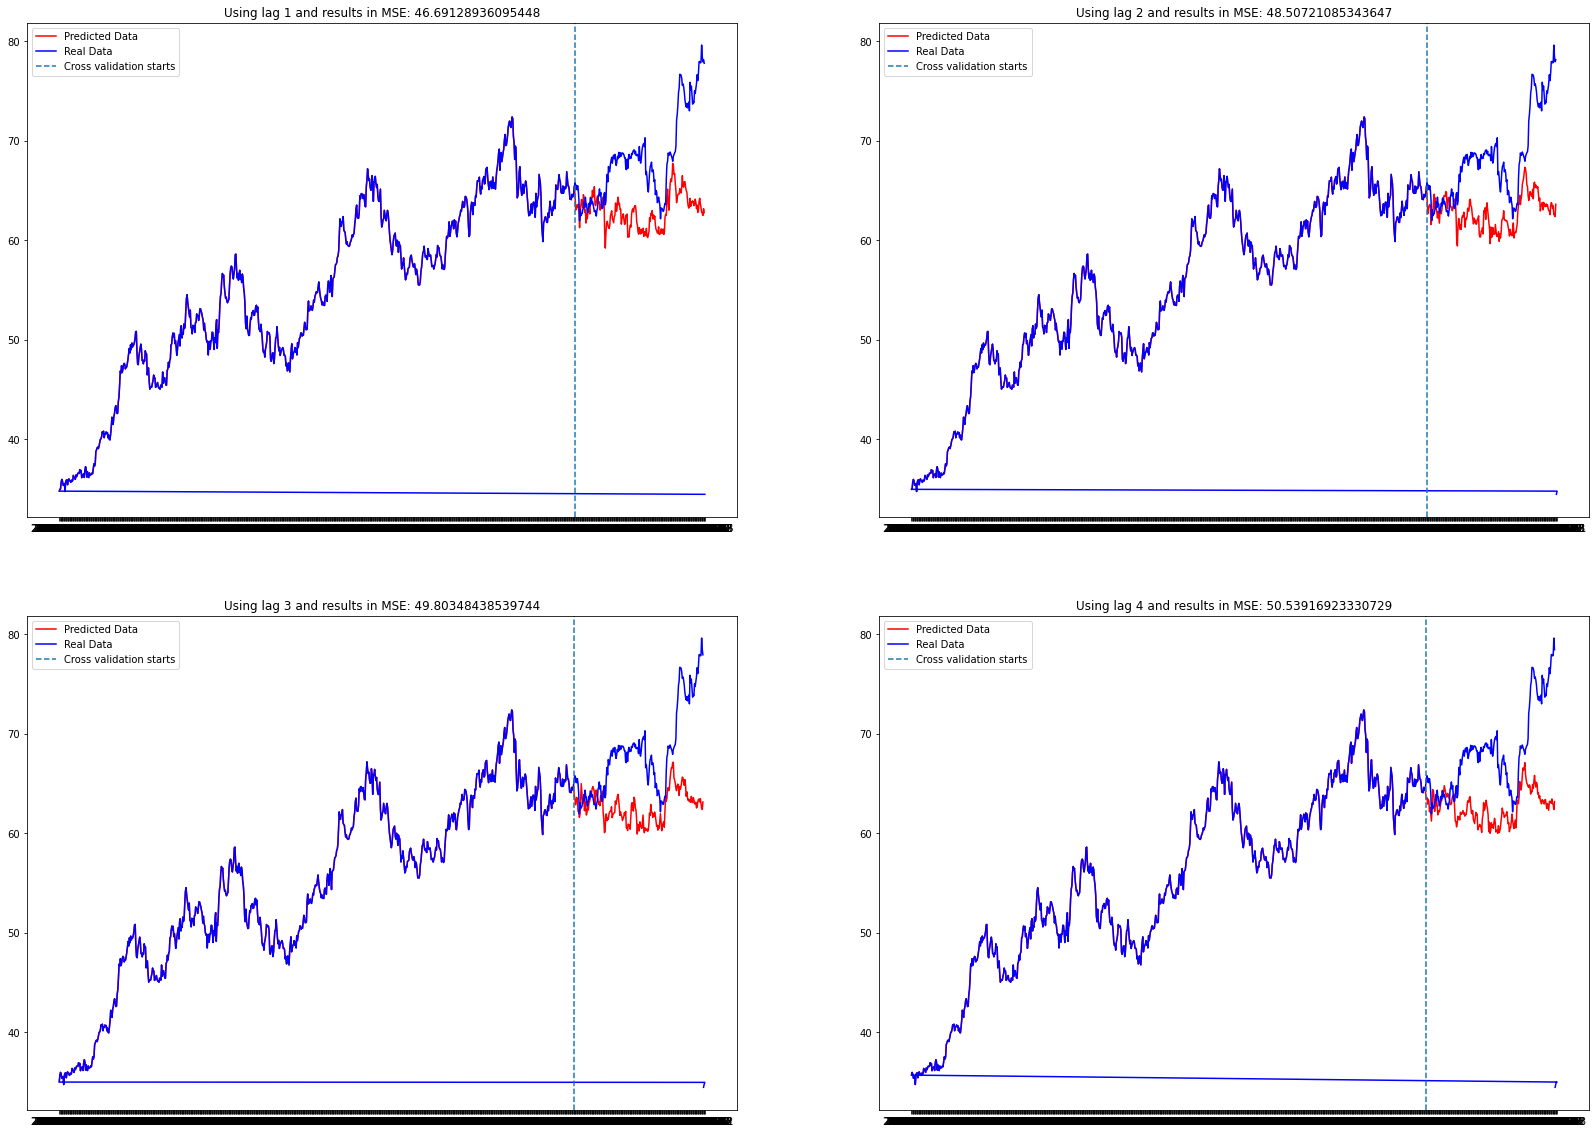

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
plot_cv(LinearRegression(fit_intercept=False), new_tdf_1)

Unexpectedly, the model does not work out quite well for the validation set, but let's see how it performs in the test set.

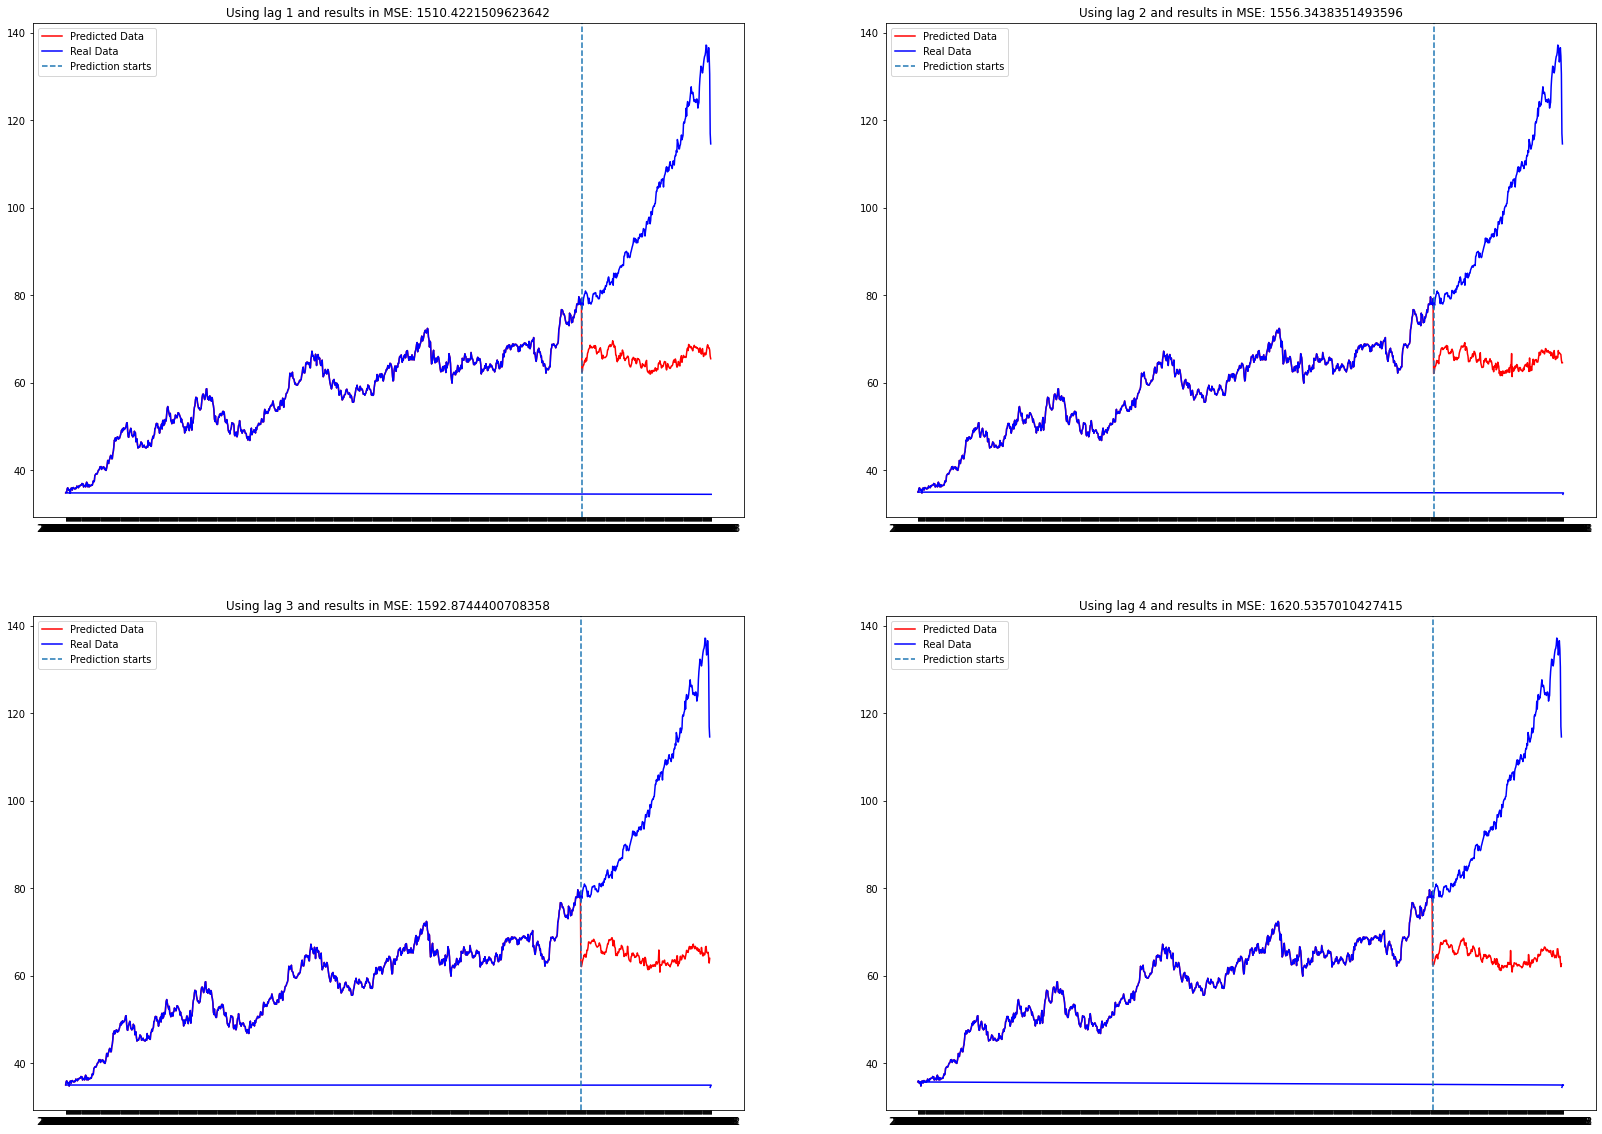

In [28]:
plot_test(LinearRegression(fit_intercept=False), new_tdf_1)

The performance is even worse in the test set. As suspected earlier, one reason may explain this is that the chosen stocks demonstrated rather constant relationship with CBOE in the training period but not in the validation period.

At last, we finally add CBOE's own features back to the dataframe and try to use neural networks to make prediction. This time will use the first financial dataset, but rather than just including the "close" prices, all prices ("open", "high" and "low") and log-scaled volume will also be included. Then each variable will minus "close_CBOE" and form a difference variable, the ADF test is then used to test the stationarity of this variable, just as what we did before.

Only the variable considered stationary will remain in the dataset, otherwise be dropped. Finally, all the CBOE features "open_CBOE", "high_CBOE", "low_CBOE", "volume_CBOE", and most importantly a delayed form of "close_CBOE" will be added to the dataset.

In [41]:
from tensorflow import keras
from sklearn.metrics import mean_squared_error

In [30]:
n = 802
# Create the difference dataframe
diff_df = finance.df[["date", "close_CBOE"]][:n].copy(deep=True)
new_tdff = finance.df.copy(deep=True)
new_tdff.dropna(axis=1, inplace=True)
new_tdff.drop(["open_CBOE", "close_CBOE", "high_CBOE", "low_CBOE", "volume_CBOE"], axis=1, inplace=True)
for name in list(new_tdff.columns[1:]):
    if "volume" in name:
        diff_df[str("diff_") + str(name)] = np.log(new_tdff[name][:n]) - diff_df["close_CBOE"][:n]
    else:
        diff_df[str("diff_") + str(name)] =new_tdff[name][:n] - diff_df["close_CBOE"][:n]

# Apply ADF test to the difference variables
from statsmodels.tsa.stattools import adfuller
adf_stat = pd.DataFrame(np.zeros((len(diff_df.columns[2:]), 2)), index = list(diff_df.columns[2:]), columns = ["Statistic", "p_value"])
for name in list(diff_df.columns[2:]):
    adf_stat["Statistic"][str(name)] = adfuller(diff_df[name])[0]
    adf_stat["p_value"][str(name)] = adfuller(diff_df[name])[1]

# Filter out the significant variables
adf_filtered = adf_stat[adf_stat["Statistic"] < 0].copy(deep=True)
adf_filtered = adf_filtered[adf_filtered["p_value"] < 0.05]

dependent_variables = [name[5:] for name in adf_filtered.index]

# Refine the dataframe
new_tdf_3 = new_tdff.copy(deep=True)
for stock in list(new_tdf_3.columns):
    if stock not in dependent_variables:
        new_tdf_3.drop(stock, axis=1, inplace=True)
new_tdf_3 = pd.DataFrame(cboe.loc[:,["date","close_CBOE"]]).join(new_tdf_3).copy()
new_tdf_3 = new_tdf_3.iloc[:,:2].join((wday.join(new_tdf_3.iloc[:,2:])))

The graph of the chosen variables and their names are as below.

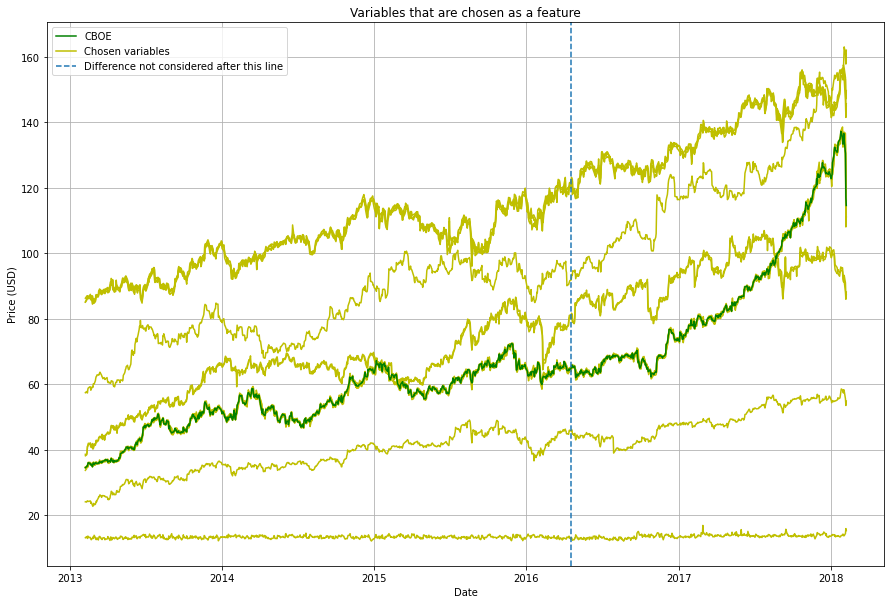

['open_AIZ', 'low_AIZ', 'open_CB', 'high_CB', 'low_CB', 'high_CME', 'low_HIG']


In [57]:
fig = plt.figure(figsize=(15,10))
plt.plot(pd.to_datetime(new_tdf_3.iloc[:,0]), new_tdf_3.iloc[:,7:], "y")
plt.plot(pd.to_datetime(new_tdf_3.iloc[:,0]), new_tdf_3.iloc[:,1], "g", label="CBOE")
plt.plot([],[],"y", label="Chosen variables")
plt.axvline(x=pd.to_datetime(new_tdf_3.iloc[:,0])[n], linestyle="dashed", label="Difference not considered after this line")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.title("Variables that are chosen as a feature")
plt.legend()
plt.grid()
plt.show()
print(dependent_variables)

In [33]:
# Extract the CBOE features
cboe_features = cboe.copy(deep=True)
cboe_features.drop(["date"], axis=1, inplace=True)
cboe_features.rename(columns={"close_CBOE": "close_CBOE_past"}, inplace=True)
# Add those features to the dataframe
new_tdf_3 = new_tdf_3.iloc[:,:7].join(cboe_features.join(new_tdf_3.iloc[:,7:]))

In [34]:
print(new_tdf_3.columns)

Index(['date', 'close_CBOE', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'open_CBOE',
       'high_CBOE', 'low_CBOE', 'close_CBOE_past', 'volume_CBOE', 'open_AIZ',
       'low_AIZ', 'open_CB', 'high_CB', 'low_CB', 'high_CME', 'low_HIG'],
      dtype='object')


Since the values of volume are extremely huge compared to the prices, they are scaled down using log.

In [35]:
new_tdf_3["volume_CBOE"] = np.log(new_tdf_3["volume_CBOE"])

In [36]:
print(new_tdf_3.head())

         date  close_CBOE  Mon  Tue  Wed  Thu  Fri  open_CBOE  high_CBOE  \
0  2013-02-08       34.46    0    0    0    0    1      34.39      34.68   
1  2013-02-11       34.78    1    0    0    0    0      34.50      34.87   
2  2013-02-12       34.96    0    1    0    0    0      34.90      35.10   
3  2013-02-13       34.99    0    0    1    0    0      34.92      35.08   
4  2013-02-14       35.69    0    0    0    1    0      35.05      35.87   

   low_CBOE  close_CBOE_past  volume_CBOE  open_AIZ  low_AIZ  open_CB  \
0     33.64            34.46    13.048562     38.55    38.09    85.10   
1     34.17            34.78    13.398142     38.50    38.36    85.93   
2     34.80            34.96    13.228511     39.15    39.05    86.34   
3     34.85            34.99    12.830681     41.06    40.83    86.89   
4     34.59            35.69    13.569739     41.15    41.06    86.13   

   high_CB  low_CB  high_CME  low_HIG  
0    86.23  85.010   57.3600    24.04  
1    86.77  85.560   57.

Lag 1 is used because it contains the minimum number of features, so the dataset is smaller and the training is faster.

In [37]:
# Create a lag 1 dataset
n_dataset = Dataset(new_tdf_3, 1)
n_dataset.gen_x()
n_dataset.gen_y()
x_train, y_train, x_test, y_test = n_dataset.train_test_split()

In [38]:
print(x_train.head())
print(y_train.head())

   Mon  Tue  Wed  Thu  Fri  open_CBOE_1  high_CBOE_1  low_CBOE_1  \
1    1    0    0    0    0        34.39        34.68       33.64   
2    0    1    0    0    0        34.50        34.87       34.17   
3    0    0    1    0    0        34.90        35.10       34.80   
4    0    0    0    1    0        34.92        35.08       34.85   
5    0    0    0    0    1        35.05        35.87       34.59   

   close_CBOE_past_1  volume_CBOE_1  open_AIZ_1  low_AIZ_1  open_CB_1  \
1              34.46      13.048562       38.55      38.09      85.10   
2              34.78      13.398142       38.50      38.36      85.93   
3              34.96      13.228511       39.15      39.05      86.34   
4              34.99      12.830681       41.06      40.83      86.89   
5              35.69      13.569739       41.15      41.06      86.13   

   high_CB_1  low_CB_1  high_CME_1  low_HIG_1  
1      86.23    85.010     57.3600      24.04  
2      86.77    85.560     57.7300      23.95  
3      8

In [39]:
# The training set is separated into training period and validation period
cv = int(x_train.shape[0] * 0.8)
end = x_train.shape[0]
X_train = x_train[:cv].values
Y_train = y_train[:cv].values
X_valid = x_train[cv:].values
Y_valid = y_train[cv:].values

A model with 3 layers and 100 nodes in each is created. The Rectified Linear Unit function is used as the activation function since we expect most of the weight would be non-zero and most importantly it is fast to compute. 

While mean squared error is used as the loss function we aim to minimize, the Adaptive Momentum Estimation is used as the optimizer. The latter preserves the momentum of the descent while allowing room to constantly rectify its direction, therefore is expected to work well in a deep neural network like this. A rather small learning rate 0.001 is chosen and beta1 and beta2 are set at high 0.9 and 0.99 respectively as high momentum.

In [42]:
model_1 = keras.models.Sequential([
    keras.layers.Dense(100, activation="relu", kernel_initializer='he_normal', input_shape=X_train.shape[1:]),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(1)
])
model_1.compile(loss="mean_squared_error", optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9,beta_2=0.999), metrics=["mse"])

In [43]:
history = model_1.fit(X_train, Y_train, epochs=1000, batch_size=1)

Epoch 1/1000
804/804 [==============================] - 0s 456us/step - loss: 13.6089 - mse: 13.6089
Epoch 2/1000
804/804 [==============================] - 0s 456us/step - loss: 3.6330 - mse: 3.6330
Epoch 3/1000
804/804 [==============================] - 0s 429us/step - loss: 2.9255 - mse: 2.9255
Epoch 4/1000
804/804 [==============================] - 0s 446us/step - loss: 2.9079 - mse: 2.9079
Epoch 5/1000
804/804 [==============================] - 0s 446us/step - loss: 2.2785 - mse: 2.2785
Epoch 6/1000
804/804 [==============================] - 0s 444us/step - loss: 2.6575 - mse: 2.6575
Epoch 7/1000
804/804 [==============================] - 0s 433us/step - loss: 2.2064 - mse: 2.2064
Epoch 8/1000
804/804 [==============================] - 0s 446us/step - loss: 1.5707 - mse: 1.5707
Epoch 9/1000
804/804 [==============================] - 0s 432us/step - loss: 1.9943 - mse: 1.9943
Epoch 10/1000
804/804 [==============================] - 0s 432us/step - loss: 1.8794 - mse: 1.8794
Epoch 1

Text(0.5, 0, 'Epochs')

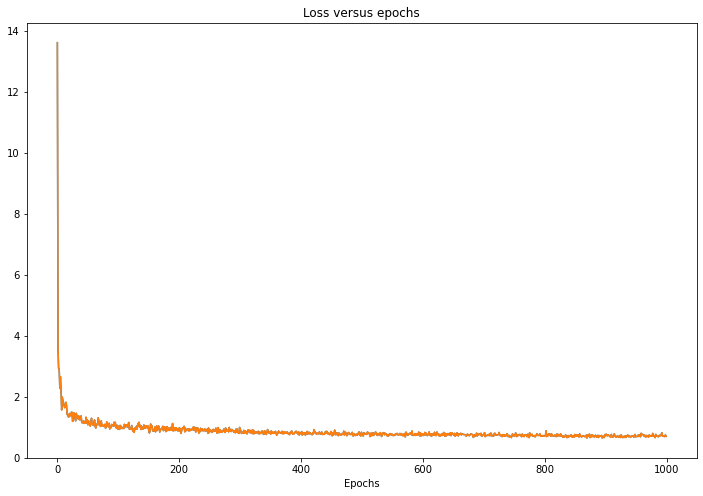

In [55]:
plt.figure(figsize=(12,8))
plt.plot(pd.DataFrame(history.history))
plt.title("Loss versus epochs")
plt.xlabel("Epochs")

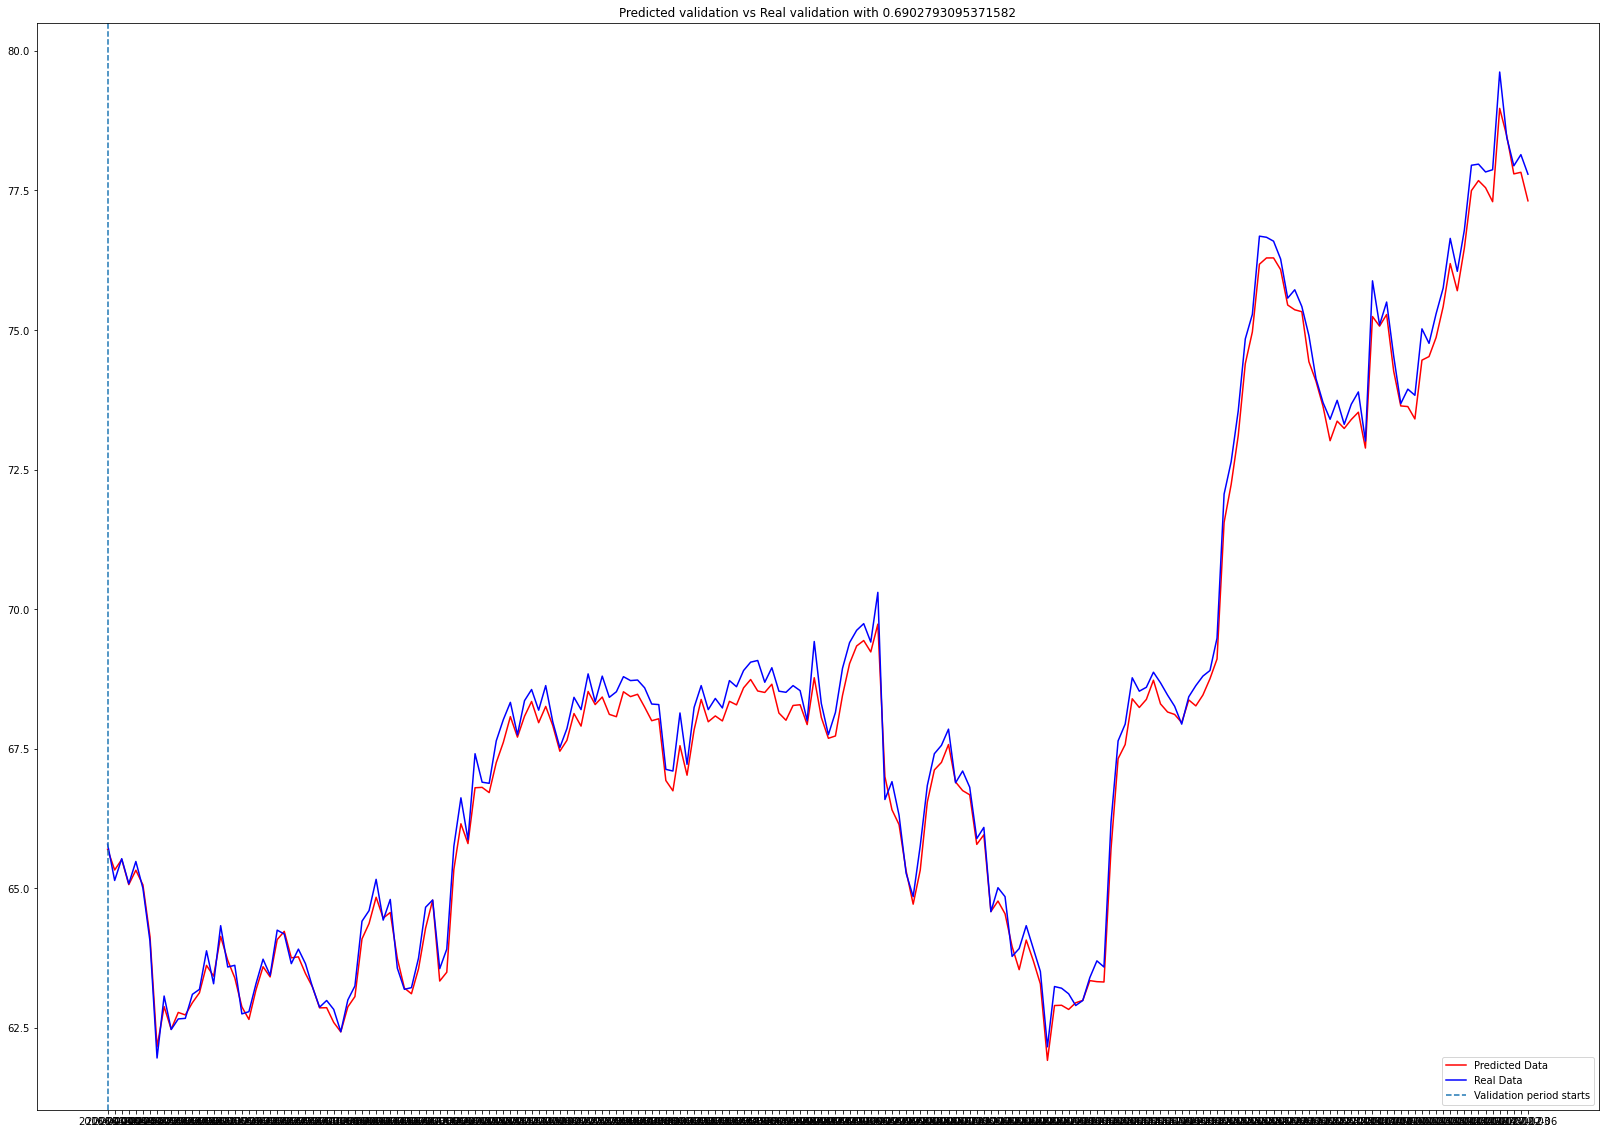

In [44]:
y_pred = model_1.predict(X_valid)
y_pred = y_pred.reshape(end-cv)
plt.figure(figsize=(28, 20))
y_series = pd.Series(list(n_dataset.y_df[cv:end]), index=n_dataset.dates[cv:end])
y_predict = pd.Series(y_pred, index=n_dataset.dates[cv:end])
mse = mean_squared_error(Y_valid, y_pred)
plt.plot(y_predict, "r", label="Predicted Data")
plt.plot(y_series, "b", label="Real Data")
plt.axvline(x=n_dataset.dates[cv], linestyle="dashed", label="Validation period starts")
plt.title(f"Predicted validation vs Real validation with {mse}")
plt.legend()
plt.show()

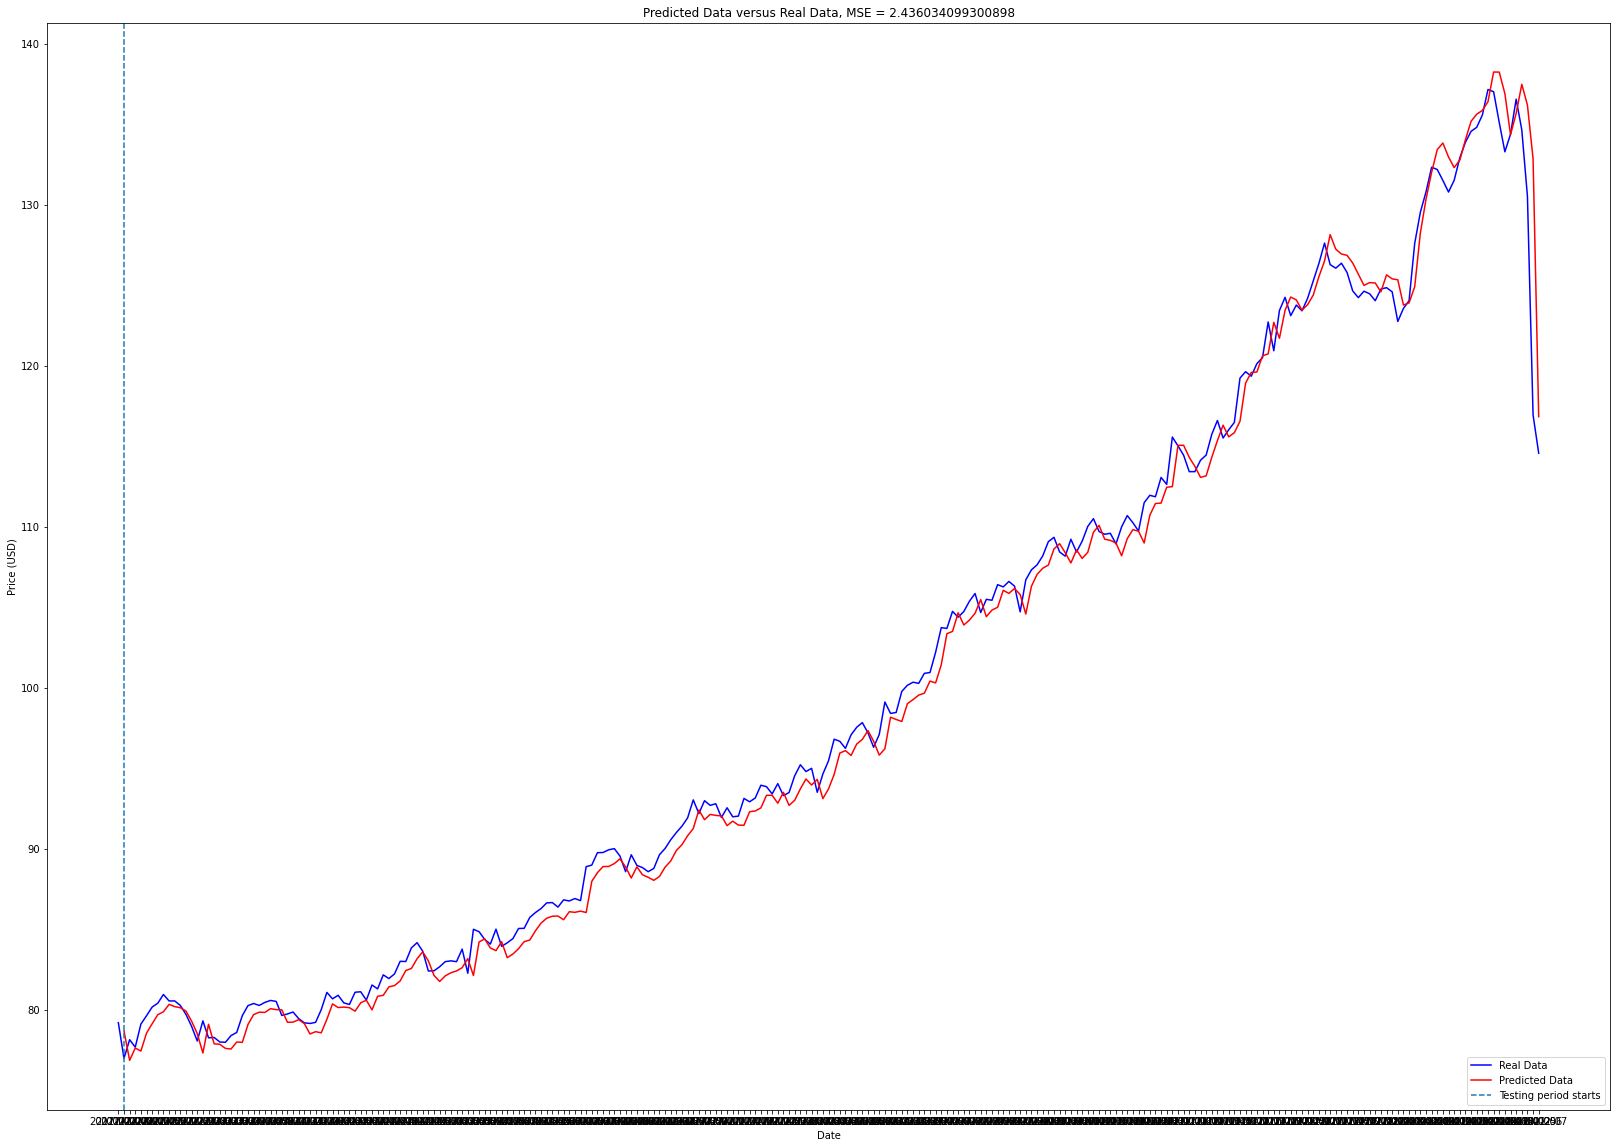

In [45]:
y_pred = model_1.predict(x_test)
y_series = pd.Series(list(n_dataset.y_df[end:]), index=n_dataset.dates[end:])
y_predict = pd.Series(list(y_pred), index=n_dataset.dates[n_dataset.n:])
mse = mean_squared_error(y_test, y_pred)
plt.figure(figsize=(28,20))
plt.plot(y_series, "b", label="Real Data")
plt.plot(y_predict, "r", label="Predicted Data")
plt.axvline(x=n_dataset.dates[n_dataset.n], linestyle="dashed", label="Testing period starts")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.title("Predicted Data versus Real Data, MSE = {mse}".format(mse=mse))
plt.legend()
plt.show()

In [59]:
model_1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 50)                1200      
_________________________________________________________________
dense_13 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_14 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 51        
Total params: 6,351
Trainable params: 6,351
Non-trainable params: 0
_________________________________________________________________
